<h1 style="font-size:50px; text-align: center; margin-bottom: 10px">Strain Calculations Demo</h1>
This notebook contains a demo of how use the strain calculation functions to find the characteristic strain and other quantities.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import astropy.units as u

from importlib import reload

# import sensitivity curves code from '/code' folder
import sys
sys.path.append("../LISA_detections")
import strain_calculations as strain
reload(strain)

%config InlineBackend.figure_format = 'retina'
plt.rc("font", family="serif")

# Characteristic Strain - Circular Binaries
For circular binaries, all of the gravitational wave power is emitted in the 2nd harmonic and so the calculation of the characteristic strain is simpler in this case.

We can use the `characteristic_strain_circ(Mc, D, f)` function to find the characteristic strain a single circular binary. This calculates the characteristic strain using
$$ h_{\rm c, n}^2 = \frac{2}{3 \pi^{4/3}} \frac{(G \mathcal{M}_c)^{5/3}}{D_{\rm L}^2 c^3} \frac{1}{f_{\rm GW}^{1/3}}  $$

In [2]:
Mc = 3 * u.Msun
D = 8.2 * u.kpc
f = 5e-4 * u.Hz

print(strain.characteristic_strain_circ(Mc, D, f))

1.5100502859514347e-16


This also works for an array of binaries, let's create a grid of BH-NS binaries and make a contour plot of the characteristic strain.

In [3]:
# calculate chirp masses from mass combinations
ns_masses = np.linspace(1, 3, 10)
bh_masses = np.linspace(5, 35, 50)
MNS, MBH = np.meshgrid(ns_masses, bh_masses)
masses = np.sort(strain.chirp_mass(MBH, MNS).flatten())

# space out distances logarithimically
distances = np.logspace(0, 4, num=500)

# calculate a grid
Mc, D = np.meshgrid(masses, distances)
hc = strain.characteristic_strain_circ(Mc * u.M_sun, D * u.kpc, 5e-4 * u.Hz)

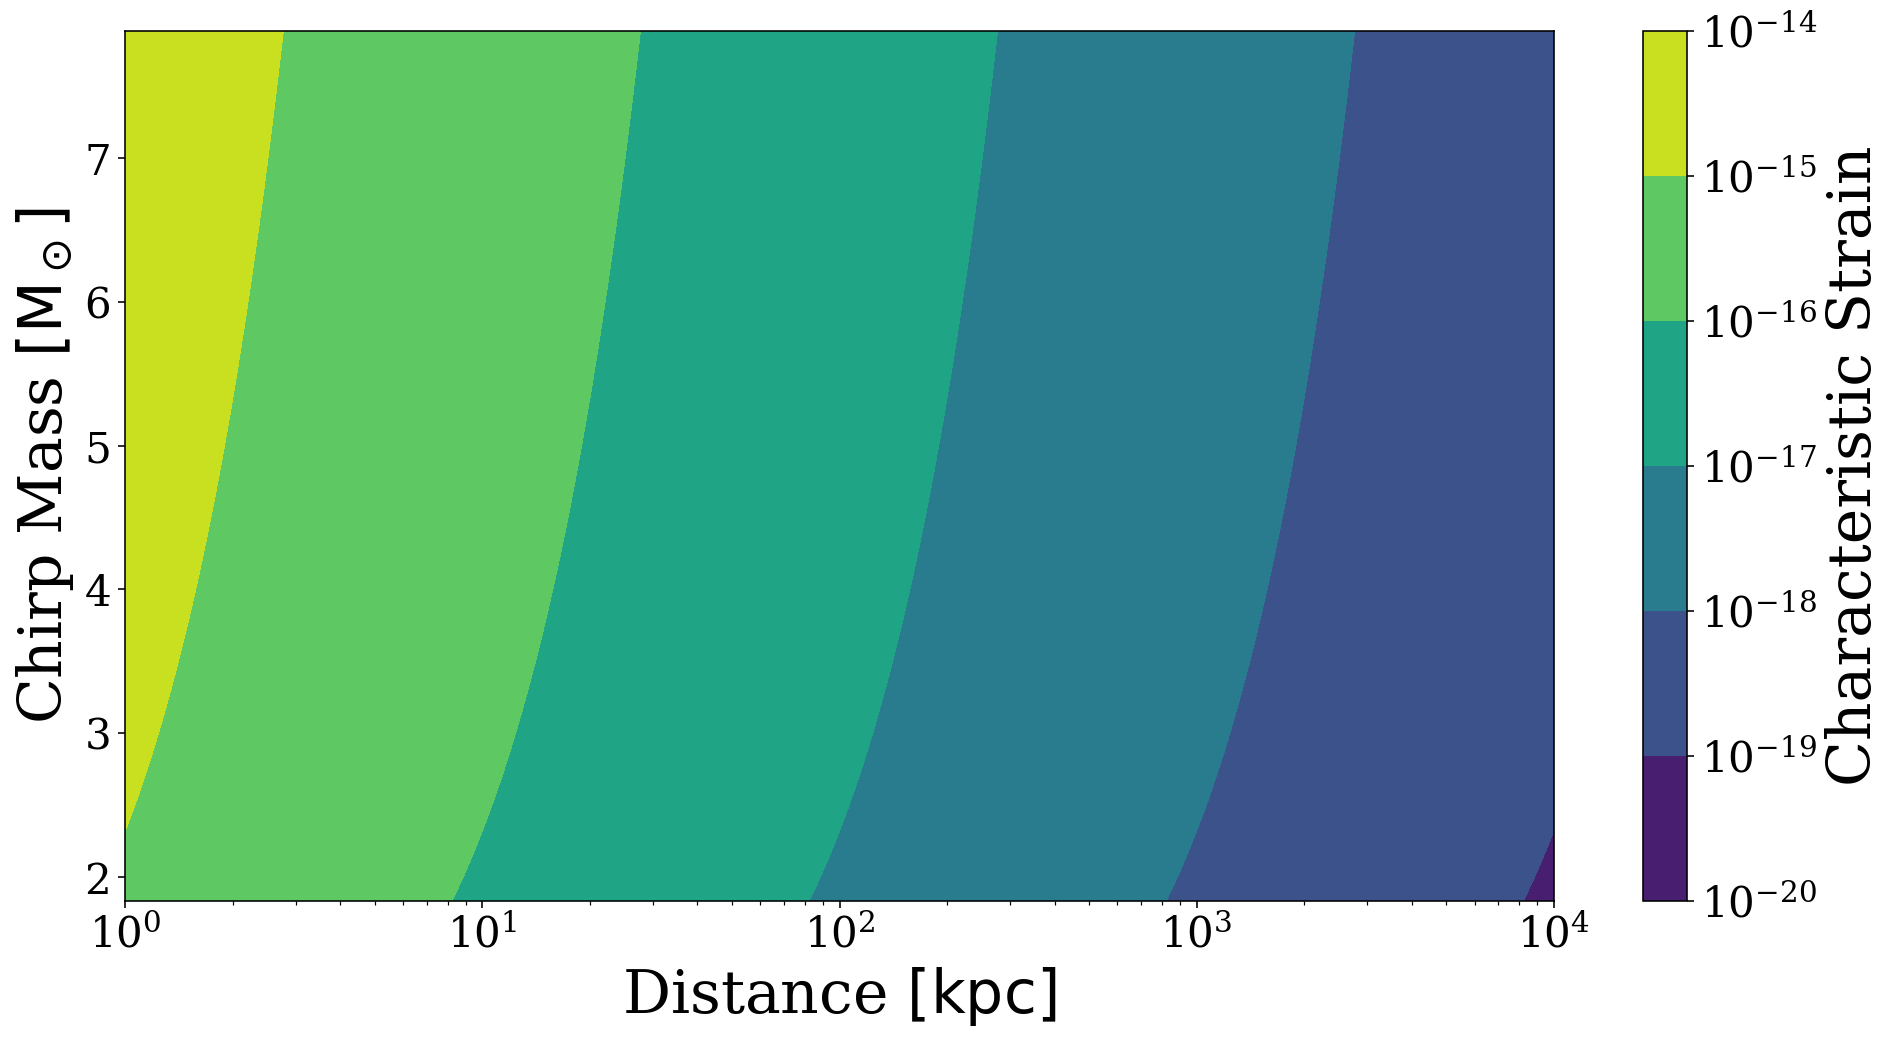

In [4]:
fig, ax = plt.subplots(figsize=(16, 8))
fs = 30

# plot filled contours of the characteristic strain
cs = ax.contourf(D, Mc, hc, cmap="viridis", norm=colors.LogNorm())
    
# add a colourbar
cbar = fig.colorbar(cs)
cbar.set_label(label="Characteristic Strain", fontsize=fs)
cbar.ax.tick_params(labelsize=fs * 0.7)

ax.tick_params(axis='both', which='major', labelsize=fs * 0.7)
ax.set_xscale("log")
ax.set_xlabel(r"Distance $[\rm kpc]$", fontsize=fs)
ax.set_ylabel(r"Chirp Mass $[\rm M_\odot]$", fontsize=fs)

plt.show()

# Characteristic Strain - Eccentric Binaries
For eccentric binaries, the gravitational wave power is distributed across many different harmonics and so calculating the strain is slightly more complicated.
$$ h_{\rm c, n}^2 = \frac{2}{3 \pi^{4/3}} \frac{(G \mathcal{M}_c)^{5/3}}{D_{\rm L}^2 c^3} \frac{1}{f_n^{1/3}} \left(\frac{2}{n} \right)^{1/3} \frac{g(n, e)}{F(e)} $$

#### Distribution of GW power in Harmonics
The general equation for the characteristic strain has a factor of `g(n, e) / F(e)`. This terms gives the distribution of gravitational wave power across the harmonics. The function `g(n,e)` (Peters, 1963) returns the *relative* gravitational wave power in the nth harmonic for a binary with eccentricity e. Whilst `F(e)` is defined as the sum of `g(n,e)` over infinite harmonics. Therefore we see that `g(n, e) / F(e)` is the fraction of gravitational wave power in the nth harmonic for a binary with eccentricity e.

Although `g(n,e)` is a complicated combination of Bessel functions, we can plot `g(n, e) / F(e)` for different eccentricities and harmonics to get a sense of its shape. This plot is inspired by Figure 3 of Peters, 1963.

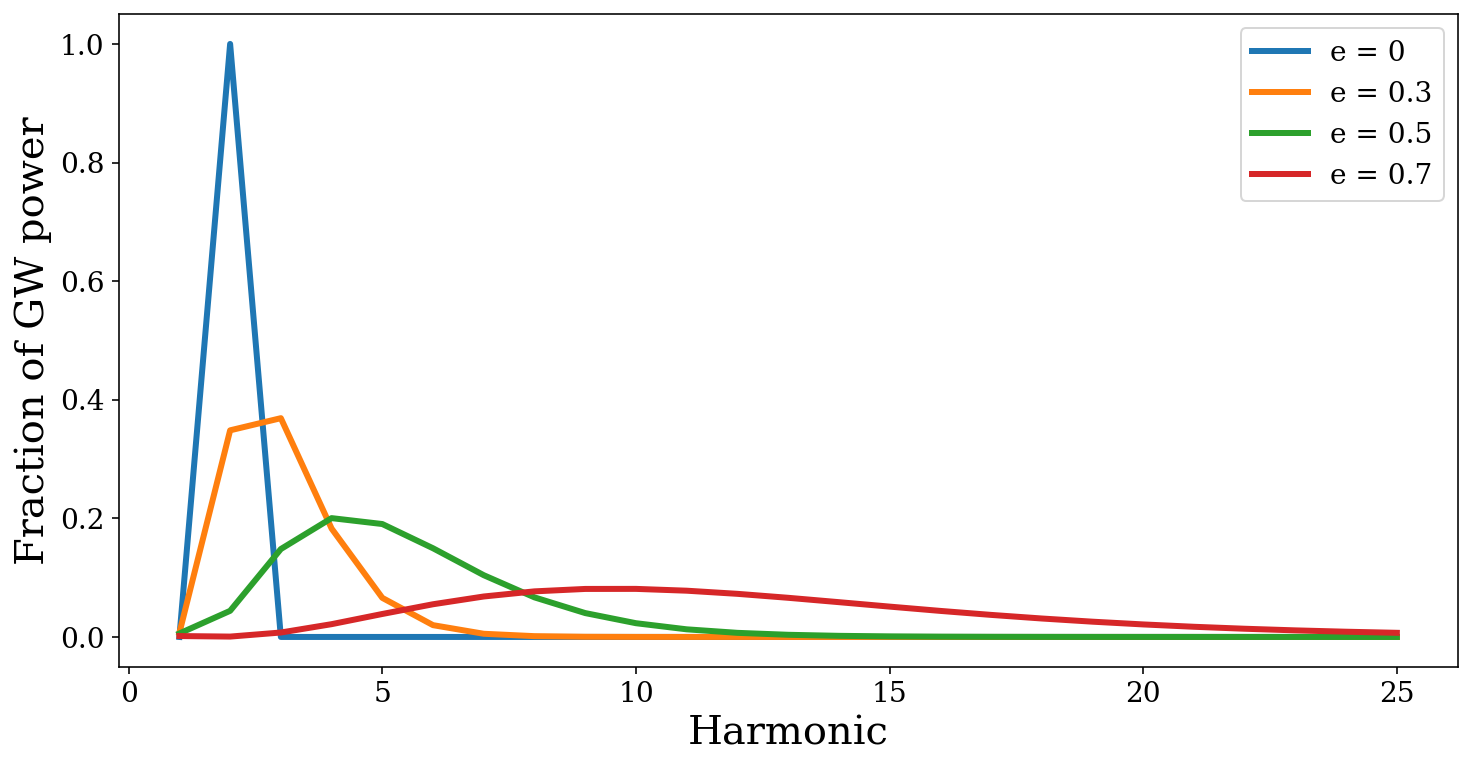

In [5]:
# focus on the first 25 harmonics
harmonics = np.linspace(1, 25, 25)

fig, ax = plt.subplots(1, figsize=(12, 6))
fs = 20

# plot g(n, e) / F(e) for these harmonics and several eccentricities
for e in [0, 0.3, 0.5, 0.7]:
    ax.plot(harmonics, [strain.g(n, e) for n in harmonics] / strain.F(e), lw=3, label="e = {0}".format(e))

ax.set_xlabel("Harmonic", fontsize=fs)
ax.set_ylabel("Fraction of GW power", fontsize=fs)
ax.tick_params(axis="both", which="major", labelsize=0.7 * fs)
    
ax.legend(fontsize=0.7 * fs)
    
plt.show()

### Another BH-NS grid with eccentricities
Now we can repeat the plot from before but keep all the binaries at a fixed distance (centre of the Milky Way) and vary only the mass and eccentricity. We show the `total_characteristic_strain(Mc, D, f, e, nmax)` function here and limit the harmonics to `nmax=25` since we know from the plot above that if we cap the eccentricity at 0.7 then we don't need more than 25 of the harmonics.

In [6]:
# calculate chirp masses from mass combinations
ns_masses = np.linspace(1, 3, 10)
bh_masses = np.linspace(5, 35, 50)
MNS, MBH = np.meshgrid(ns_masses, bh_masses)
masses = np.sort(strain.chirp_mass(MBH, MNS).flatten())

# space out eccentricies
eccentricities = np.logspace(-2, np.log10(0.7), num=25)

# calculate a grid
Mc, e = np.meshgrid(masses, eccentricities)
hc = strain.total_characteristic_strain(Mc * u.M_sun, 8.2 * u.kpc, 5e-4 * u.Hz, e, nmax=25)

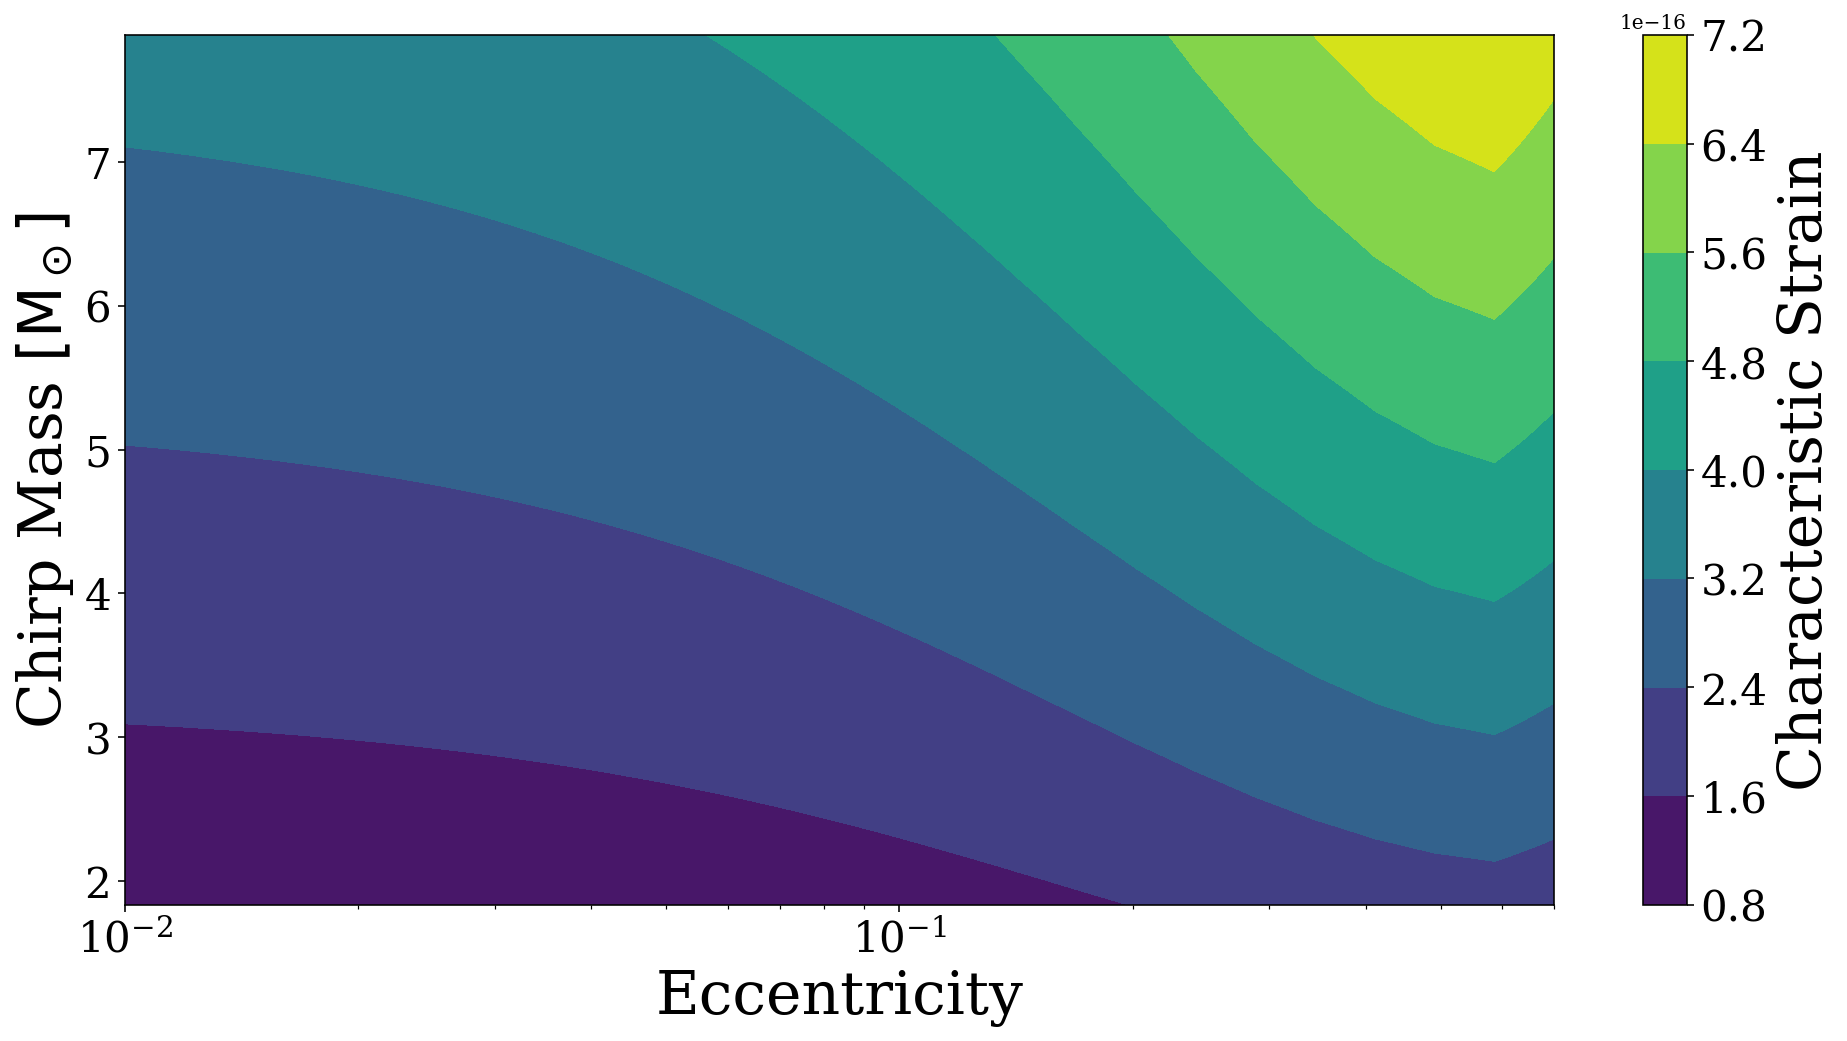

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
fs = 30

# plot filled contours of the characteristic strain
cs = ax.contourf(e, Mc, hc, cmap="viridis")
    
# add a colourbar
cbar = fig.colorbar(cs)
cbar.set_label(label="Characteristic Strain", fontsize=fs)
cbar.ax.tick_params(labelsize=fs * 0.7)

ax.tick_params(axis='both', which='major', labelsize=fs * 0.7)
ax.set_xscale("log")
ax.set_xlabel(r"Eccentricity", fontsize=fs)
ax.set_ylabel(r"Chirp Mass $[\rm M_\odot]$", fontsize=fs)

plt.show()